In [51]:
CONFIG_PATH = "configs/small_sample_sub_minority.yml"
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
config = get_config(CONFIG_PATH, "_curation", print_config = False)
active_user_votes_thres = config["active_user_votes_thres"]
batch_size = config["batch_size"]

GPU ready...
Smart using cuda:0


In [52]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from model import get_best_model
from matplotlib import pyplot as plt
from venn import venn, pseudovenn
from utils import get_user_reps, get_bool_vec, record_existing_votes
import time
import re
submission_sentiment_map = {}
submission_class_map = {}

##### Preprocess

Load model and data

In [53]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)
model, token_embedding = get_best_model(config, categorical_features, string_features, original_feature_map)
model.eval()
all_users = list(range(num_all_users + 1))

------------------ 2022-08-14 04:34:19 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:349 get_model_input
Loading prepared data...
------------------ 2022-08-14 04:34:19 ------------------
------------------ 2022-08-14 04:34:22 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 21.  original_token_num num val: 30522
------------------ 2022-08-14 04:34:22 ------------------
------------------ 2022-08-14 04:34:23 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 22.  latest_token_num num val: 153833
------------------ 2022-08-14 04:34:23 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-08-14 04:34:24 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:113 load_model
Loading best model...
------------------ 2022-08-14 04:34:24 ------------------


Collect submissions and active users in different subreddits

In [ ]:
def get_subreddits_submissions(train_data:pd.DataFrame, test_data:pd.DataFrame, user_votes_thres = 0):
    subreddit_votes_counter = Counter()
    subreddit_active_users = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    all_submissions = dict()
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_active_users[row["SUBREDDIT"]][row["USERNAME"]] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    for subreddit in subreddit_active_users:
        users_vote_count = subreddit_active_users[subreddit]
        subreddit_active_users[subreddit] = {user for user in users_vote_count if users_vote_count[user] >= user_votes_thres}
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]]:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions

subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions = get_subreddits_submissions(train_data, test_data, user_votes_thres = active_user_votes_thres) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data
# print(sorted([(subreddit, len(subreddit_active_users[subreddit])) for subreddit in subreddit_active_users], key = lambda x: x[1], reverse = True))

Record down existing votes

So that we can use them to substitute the predicted votes

In [55]:
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)

#### Predict votes for all the users on all submissions

Define required functions

In [56]:
from typing import Union
# from tqdm import tqdm
from tqdm.notebook import tqdm
from train import evaluate_model
from model import get_tokenizer

def convert_group_users_subreddit_submissions_data(group_users:Union[set,list], unique_submissions:dict):
    group_users_submissions_data = []
    if type(unique_submissions) == dict:
        unique_submissions = pd.DataFrame(list(unique_submissions.values()))

    for user in tqdm(group_users):
        # for submission_id in unique_submissions:
        #     submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
        #     submission["USERNAME"] = user
        #     group_users_submissions_data.append(submission)
        submissions = unique_submissions.copy(deep=True)
        submissions["USERNAME"] = [user] * len(submissions) # it doesn't matter whether the user itself is in UPVOTED_USERS / DOWNVOTED_USERS: we will substitute it with real votes
        group_users_submissions_data.append(submissions)

    group_users_submissions_data = pd.concat(group_users_submissions_data,axis=0)
    return group_users_submissions_data
def predict_group_users_submissions_votes(model, group_users_submissions_data, batch_size):
    # predict unseen votes
    return evaluate_model(config, model, data=group_users_submissions_data, weights = None, batch_size=config["batch_size"], sample_voted_users=False, extra_input = extra_input, ret = "prediction") # ndarray size: (3423664, 1)
pred_all_user_submission_vote_score_matrix = None

# model.device = "cuda:0"
def get_group_user_submission_vote_score_matrix(predicted_group_users_submissions_votes:np.ndarray, group_users, group_users_submissions_data:pd.DataFrame, existing_votes, existing_pred_user_submission_vote_score_matrix = None, upvote_confidence_thres = 0):
    all_sub_ids = group_users_submissions_data["SUBMISSION_ID"].unique()
    if existing_pred_user_submission_vote_score_matrix is not None:
        pred_user_submission_vote_score_matrix = existing_pred_user_submission_vote_score_matrix
    else:
        pred_user_submission_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_user_submission_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids) # use ground truth vote if available, -1 for not in data
    each_submission_votes = {}
    each_user_confidence = defaultdict(list)
    submission_ids = group_users_submissions_data["SUBMISSION_ID"].to_numpy()
    usernames = group_users_submissions_data["USERNAME"].to_numpy()
    for row_i in tqdm(range(len(group_users_submissions_data))):
        submission_id = submission_ids[row_i]
        username = usernames[row_i]
        if existing_pred_user_submission_vote_score_matrix is not None:
            vote_score = existing_pred_user_submission_vote_score_matrix.at[username, submission_id]
            vote_score = float(vote_score)
            assert vote_score != -1, f"BUG: submission_id: {submission_id}, username: {username}, vote_score: {vote_score}"
        else:
            vote_score = predicted_group_users_submissions_votes[row_i, 0]
            pred_user_submission_vote_score_matrix.loc[username, submission_id] = vote_score
        if f'{username}-{submission_id}' not in existing_votes:
            vote = int(vote_score >= (0.5 + upvote_confidence_thres))
        else: # use existing votes if available
            vote = int(existing_votes[f'{username}-{submission_id}'] >= 0.5)
            
        if submission_id not in each_submission_votes:
            each_submission_votes[submission_id] = [0, 0]
        each_user_confidence[username].append(abs(vote_score - 0.5))
        pred_user_submission_vote_matrix.at[username, submission_id] = vote
        each_submission_votes[submission_id][vote] += 1
    assert (pred_user_submission_vote_matrix.to_numpy() != -1).sum() > 0
    
    # analyze user confidence
    for username in each_user_confidence:
        each_user_confidence[username] = float(np.mean(each_user_confidence[username]))
        
    # calculate %upvotes for each submission
    for submission_id in each_submission_votes:
        each_submission_votes[submission_id].append(each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])) # %upvotes
    return each_submission_votes, each_user_confidence, pred_user_submission_vote_score_matrix, pred_user_submission_vote_matrix
def get_group_users_preferred_submissions(each_submission_votes:dict, upvote_ratio_thres = 0.5):
    # sort submissions using %upvotes
    group_submissions_ranking = list(each_submission_votes.keys())
    group_submissions_ranking.sort(reverse=True, key=lambda id: each_submission_votes[id][-1])
    
    # include submissions to preferred_submissions where %upvotes is higher than threshold
    group_preferred_submissions = set()
    for submission_id in group_submissions_ranking:
        if each_submission_votes[submission_id][-1] >= upvote_ratio_thres:
            group_preferred_submissions.add(submission_id)
    
    return group_preferred_submissions, group_submissions_ranking

def get_group_users_real_vote(group_users:Union[set,list], unique_submissions:dict, existing_votes, metric = "upvote_rate"):
    all_sub_ids = list(unique_submissions.keys())
    pred_user_submission_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_user_submission_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids)
    each_submission_votes = {}
    for submission_id in unique_submissions:
        each_submission_votes[submission_id] = [0, 0]
    for username in group_users:
        for submission_id in unique_submissions:
            if f'{username}-{submission_id}' in existing_votes:
                vote = int(existing_votes[f'{username}-{submission_id}'] >= 0.5)
                pred_user_submission_vote_matrix.at[username, submission_id] = vote
                pred_user_submission_vote_score_matrix[username, submission_id] = vote
                each_submission_votes[submission_id][vote] += 1
                
    each_user_confidence = {user: [0.5] for user in group_users}
    
    # calculate %upvotes for each submission
    for submission_id in each_submission_votes:
        if metric == "upvote_rate":
            if each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1] == 0:
                metric_res = -1
            else:
                metric_res = each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])
        elif metric == "#upvote-#downvote":
            metric_res = each_submission_votes[submission_id][1] - each_submission_votes[submission_id][0]
        each_submission_votes[submission_id].append(metric_res)
        
    
    return each_submission_votes, each_user_confidence, pred_user_submission_vote_score_matrix, pred_user_submission_vote_matrix

Convert data to model input, then run model to make predictions, and obtain prediction score matrix and vote matrix. Note that we use actual votes to replace predicted votes when available.

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

In [57]:
if config["user_grouping_method"] == "predict_all_submissions":
    # Convert data to model input
    # TODO: not all users
    all_users_submissions_data = convert_group_users_subreddit_submissions_data(all_users, all_submissions)

    # run model to make predictions
    model.to(model.device)
    predicted_all_users_submissions_votes = predict_group_users_submissions_votes(model, all_users_submissions_data, batch_size)
    debug(predicted_all_users_submissions_votes=predicted_all_users_submissions_votes)

    import pickle
    pickle.dump(predicted_all_users_submissions_votes, open("output/predicted_all_users_submissions_votes.pt", "wb"))
    # predicted_all_users_submissions_votes = pickle.load(open("output/predicted_all_users_submissions_votes.pt", "rb"))

    # Obtain prediction score matrix and vote matrix. We use actual votes to replace predicted votes when available
    all_submission_votes, all_users_confidence, pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_all_users_submissions_votes, all_users, all_users_submissions_data, existing_votes)
    
    # all_users_preferred_submissions, all_preferred_submissions_ranking = get_group_users_preferred_submissions(all_submission_votes, upvote_ratio_thres = config["upvote_ratio_thres"])

Calculate Pearson correlation between users

In [58]:
if config["user_grouping_method"] == "predict_all_submissions":
    debug((pred_all_user_submission_vote_matrix==-1).any())
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix=pred_all_user_submission_vote_matrix)
    vote_score_pearson_corr = np.corrcoef(pred_all_user_submission_vote_score_matrix) # (697, 697)
    debug(vote_score_pearson_corr=vote_score_pearson_corr)

#### Perform curation on a subreddit

Select a subreddit from the most popular subreddits

In [59]:
common_subreddits_counts = subreddit_votes_counter.most_common(20)
prompt = []
for subreddit_id, vote_counts in common_subreddits_counts:
    subreddit_name_str = (original_feature_map['SUBREDDIT'][subreddit_id] + ', ') if 'SUBREDDIT' in original_feature_map else ''
    prompt.append(f"Subreddit {subreddit_id}: {subreddit_name_str}{vote_counts} votes")
prompt = "\n".join(prompt)
a_subreddit = input(f"{prompt}\nSelect a subreddit: ")
if 'SUBREDDIT' in original_feature_map:
    a_subreddit = int(a_subreddit)
    subreddit_name_str = (f" ({original_feature_map['SUBREDDIT'][a_subreddit]})")
else:
    subreddit_name_str =  ''
print_log(config["log_path"], f"Selected subreddit: {a_subreddit}{subreddit_name_str}")
a_subreddit_active_users:set = subreddit_active_users[a_subreddit]
print_log(config["log_path"], f"In train data, subreddit {a_subreddit} have {len(a_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[a_subreddit]} votes and {len(subreddit_train_submissions[a_subreddit])} unique submissions. In test data, subreddit {a_subreddit} have {len(subreddit_test_submissions[a_subreddit])} unique submissions.") 

------------------ 2022-08-14 04:35:06 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Selected subreddit: r/funny
------------------ 2022-08-14 04:35:06 ------------------
------------------ 2022-08-14 04:35:06 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
In train data, subreddit r/funny have 802 active users (who votes >= 2 times), 4722 votes and 1539 unique submissions. In test data, subreddit r/funny have 604 unique submissions.
------------------ 2022-08-14 04:35:06 ------------------


In [60]:
user_grouping_method = config["user_grouping_method"]
# user_grouping_method =  "manual" # "manual" #TODO: change this
manual_user_groups = config["manual_user_groups"]
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}
debug(user_grouping_method=user_grouping_method)


------------------ 2022-08-14 04:35:06 ------------------
DEBUG: 1 vars: ['user_grouping_method'], at <ipython-input-60-4724b0236aa0>:5 <module>
0 / 23.  user_grouping_method str len 31: interest_r/Republican_r/Liberal
------------------ 2022-08-14 04:35:06 ------------------


##### Obtain representations for active users

User representation will be used to cluster users into groups if `user_grouping_method` is "`neural`" or "`vote`"

Either use this one... (clustering using vote prediction score on submissions in this subreddit, make sure `pred_all_user_submission_vote_score_matrix` is available)

In [61]:
if pred_all_user_submission_vote_score_matrix is not None:
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix)
    subreddit_submissions_bool_vec = get_bool_vec(subreddit_test_submissions[a_subreddit].keys(), pred_all_user_submission_vote_score_matrix.shape[1])
    a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=pred_all_user_submission_vote_score_matrix[:, subreddit_submissions_bool_vec], train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

Or this one... (cluster using user_embedding or sparse actual votes)

In [62]:
if pred_all_user_submission_vote_score_matrix is None:
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], user_grouping_method = user_grouping_method)
    debug(a_subreddit_active_users_reps=a_subreddit_active_users_reps)

------------------ 2022-08-14 04:35:06 ------------------
DEBUG: 1 vars: ['a_subreddit_active_users_reps'], at <ipython-input-62-6d87cb7ec640>:9 <module>
0 / 24.  a_subreddit_active_users_reps None
------------------ 2022-08-14 04:35:06 ------------------


##### Obtain the users' political affiliations and the bias of media

In [63]:
if "interest" in user_grouping_method:
    reliability_bias_df = pd.read_csv("data/political_bias/scrape_adfontes_media/data/ad_fontes_media_sources_ratings__2022_01_17.csv")
    source_url_df = pd.read_csv("data/political_bias/ad fontes media statistics 11.2020-12.2020.csv")
    source_url_df["source"] = source_url_df["source"].map(lambda x: x.replace("-", ""))
    reliability_bias_df["source"] = reliability_bias_df["source"].map(lambda x: x.lower().replace(" ", ""))
    reliability_bias_df = source_url_df.merge(reliability_bias_df, on = "source", how = "left")
    reliability_bias_df["reliability"] = reliability_bias_df.apply(lambda row: row["reliability"] if pd.notna(row["reliability"]) else row["_reliability"], axis = 1)
    reliability_bias_df["bias"] = reliability_bias_df.apply(lambda row: row["bias"] if pd.notna(row["bias"]) else row["_bias"], axis = 1)
    reliability_bias_df = reliability_bias_df[["source", "reliability", "bias", "url"]]
    reliability_bias_df.set_index("url", inplace = True)
    print(reliability_bias_df) # .iloc[:2]

    media_url_re = "("+"|".join(reliability_bias_df.index.to_list())+")"
    media_url_re = media_url_re.replace(".", "\.")

    def get_political_bias(submission_text):
        bias = []
        urls = re.findall(media_url_re, submission_text)
        for url in urls:
            if url in reliability_bias_df.index:
                bias.append(reliability_bias_df.loc[url]["bias"])
        if bias:
            return np.mean(bias)
        else:
            return np.nan

                              source  reliability   bias
url                                                     
abcnews.go.com               abcnews        46.64  -4.66
aljazeera.com              aljazeera        45.54  -4.44
alternet.org                alternet        23.28 -19.34
americanthinker.com  americanthinker        18.41  25.36
apnews.com                        ap        49.05  -2.03
...                              ...          ...    ...
washingtontimes.com  washingtontimes        31.86  14.89
wonkette.com                wonkette        17.28 -26.75
worldtruth.tv           worldtruthtv         7.41   8.48
wnd.com                          wnd        22.33  20.57
zerohedge.com              zerohedge        25.60  14.82

[120 rows x 3 columns]


##### Cluster active users into multiple groups

In [103]:
user_grouping_method = "interest_r/Republican_r/democrats_r/Conservative_r/europe_r/Libertarian_r/VoteBlue"

In [104]:
from reddit import get_user_info

def get_user_groups(selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "neural", existing_user_votes=None, manual_user_groups=None, train_data=None):
    group_centers = None
    users_in_groups = defaultdict(set)
    if "interest" in user_grouping_method:
        interest_subreddits = [_ for _ in user_grouping_method.split(" ") if "interest" in _][0].split("_")
        interest_subreddits.remove("interest")
        interest_subreddit_active_users = {}
        for interesst_subreddit in interest_subreddits:
            interest_subreddit_active_users[interesst_subreddit] = subreddit_active_users[interesst_subreddit] - a_subreddit_active_users
        users_in_groups = {}
        for interesst_subreddit in interest_subreddits:
            other_subreddit_active_users = set()
            for other_subreddit in interest_subreddits:
                if other_subreddit != interesst_subreddit:
                    other_subreddit_active_users.update(interest_subreddit_active_users[other_subreddit])
            users_in_groups[interesst_subreddit] = interest_subreddit_active_users[interesst_subreddit] - other_subreddit_active_users
            
    if "political_affiliation" in user_grouping_method:
        user_bias = defaultdict(list)
        all_bias = train_data["SUBMISSION_TEXT"].map(get_political_bias).to_numpy()
        all_usernames = train_data["USERNAME"].to_list()
        for row_i, username in enumerate(all_usernames):
            if not np.isnan(all_bias[row_i]):
                user_bias[username].append(all_bias[row_i])
        for username in user_bias:
            user_bias[username] = np.mean(user_bias[username])
            if user_bias[username] < -10:
                users_in_groups["left"].append(username)
            elif user_bias[username] > 10:
                users_in_groups["right"].append(username)
        
    if "manual" in user_grouping_method:
        if manual_user_groups is not None:
            users_in_groups.update(manual_user_groups)
        else:
            user_preferences = defaultdict(dict)
            usernames = train_data["USERNAME"].to_list()
            votes = train_data["VOTE"].to_list()
            submissions_text = train_data["SUBMISSION_TEXT"].to_list()
            for row_i, username in enumerate(usernames):
                vote = votes[row_i]
                submission_text = submissions_text[row_i]
                if vote not in user_preferences[username]:
                    user_preferences[username][vote] = []
                user_preferences[username][vote].append(submission_text)
            all_users = list(user_preferences.keys())
            group_x = len(users_in_groups)
            for _ in range(20):
                possible_user = random.choice(all_users)
                user_info, user_info_str = get_user_info(possible_user)
                if len(input(f"Include user {possible_user}? \n{user_info_str} \n{user_preferences[possible_user]}")) > 0:
                    users_in_groups[group_x].add(possible_user)
            
    if "neural" in user_grouping_method or "votes" in user_grouping_method:
        n_groups = int(len(selected_user_i_user_map) / 5) # TODO: change how many users in a group
        debug(num_selected_users = len(selected_user_i_user_map), n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_clusters = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.cluster_centers_
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
        
    if  "single_user_as_group" in user_grouping_method or  "all_user_as_group" in user_grouping_method:
        assert existing_user_votes is not None
        all_users = list(selected_user_i_user_map.values())
        all_users.sort(key=lambda x:existing_user_votes[x])
        if  "single_user_as_group" in user_grouping_method:
            all_users = all_users[:10] + all_users[-10:]
            for i, user in enumerate(all_users):
                users_in_groups[i] = {user}
            # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
        if  "all_user_as_group" in user_grouping_method:
            users_in_groups[len(users_in_groups)] = all_users
    
    if "none" in user_grouping_method:
        users_in_groups[len(users_in_groups)] = []
            
    return users_in_groups, group_centers

if type(a_subreddit_active_users_reps) == torch.tensor: a_subreddit_active_users_reps = a_subreddit_active_users_reps.cpu()
users_in_groups, group_centers = get_user_groups(a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups, train_data = train_data)
debug(users_in_groups)

------------------ 2022-08-14 05:03:10 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-104-e10e74c5e0a2>:102 <module>
0 / 54.  ? dict {...} with 6 keys ['r/Republican', 'r/democrats', 'r/Conservative', 'r/europe', 'r/Libertarian', 'r/VoteBlue']
    r/Republican set size: 7 {...}
       item 0:  num val: 16324
       item 1:  num val: 20230
       item 2:  num val: 7530
       item 3:  num val: 24428
       item 4:  num val: 14285
       item 5:  num val: 15789
       item 6:  num val: 27444
    r/democrats set size: 2 {..}
       item 0:  num val: 23850
       item 1:  num val: 4019
    r/Conservative set size: 30 {...}
       item 0:  num val: 2051
       item 1:  num val: 27526
       item 2:  num val: 28428
       item 3:  num val: 29966
       item 4:  num val: 19740
       item 5:  num val: 27937
       item 6:  num val: 25643
       item 7:  num val: 11314
       item 8:  num val: 27317
       item 9:  num val: 13379
       item 10:  num val: 707
       item 11:  num v

##### Predict preferred submissions of each group

Select submissions to curate. Test submissions in this Subreddit or customized submission

In [105]:
if config["submission_source"] == "test_data":
    submissions_before_curation:dict = subreddit_test_submissions[a_subreddit]
elif config["submission_source"] == "custom":
    custom_submission_id = "custom_" + str(random.randint(1000000000000000, 9999999999999999))
    custom_username = input("Input author's username: ") # TODO:
    custom_title = input("Input post title: ") # 'Employee of the year' 'This is so funny!!!'
    custom_content = input("Input post content: ")
    custom_submission = pd.Series({
        'SUBMISSION_ID': custom_submission_id,
        'SUBREDDIT': a_subreddit,
        'CREATED_TIME': re.sub("[0-9][0-9]:[0-9][0-9]:[0-9][0-9] ", "", time.ctime(time.time())),
        'USERNAME': 9271, # TODO:
        'VOTE': 1.0,
        'TITLE': custom_title,
        'AUTHOR': custom_username,
        '#_COMMENTS': 0,
        'NSFW': 'false',
        'SCORE': 0,
        'UPVOTED_%': 0.5,
        'LINK': '',
        'SUBMISSION_TEXT': (custom_title + " [SEP] " + custom_content) if custom_content != "" else custom_title,
        'UPVOTED_USERS': [], # TODO:
        'DOWNVOTED_USERS': []}
    )
    submissions_before_curation = {custom_submission_id: custom_submission}
    print(submissions_before_curation)
    
pred_group_votes_info = {}

Analyze submissions content

In [106]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "google-service-account-file.json"
from google.cloud import language_v1
import multiprocessing
client = language_v1.LanguageServiceClient()


# submission_text_map = test_data[["SUBMISSION_ID", "SUBMISSION_TEXT"]].drop_duplicates("SUBMISSION_ID").set_index("SUBMISSION_ID").to_dict()['SUBMISSION_TEXT']

def get_submissions_text(submission_ids):
    submissions_text = []
    for submission_id in submission_ids:
        # if "SUBMISSION_ID" in original_feature_map:
        #     submission_id = original_feature_map["SUBMISSION_ID"][submission_id]
        # submissions_text.append(submission_text_map[submission_id])
        submissions_text.append(submissions_before_curation[submission_id]["SUBMISSION_TEXT"])
        
    return submissions_text



def post_analysis(content):
    document = language_v1.Document(
        content=content, type_=language_v1.Document.Type.PLAIN_TEXT
    )
    try:
        sentiment_score = client.analyze_sentiment(document=document).document_sentiment.score
        content_classes = [cls.name for cls in client.classify_text(document=document).categories]
        return (sentiment_score, content_classes)
    except Exception as e:
        return (None, [])

def post_analysis_batch(contents:list):
    cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=cores)
    return pool.map(post_analysis, contents)


submissions_before_curation_ids = list(submissions_before_curation.keys())
submissions_before_curation_text = get_submissions_text(submissions_before_curation_ids)
submissions_text_analysis = post_analysis_batch(submissions_before_curation_text)
for sub_i, submission_id in enumerate(submissions_before_curation_ids):
    sentiment_score, content_classes = submissions_text_analysis[sub_i]
    submission_sentiment_map[submission_id] = sentiment_score
    submission_class_map[submission_id] = content_classes

Set parameters

In [107]:
batch_size = 1024
upvote_ratio_thres = 0.5 # TODO: # config["upvote_ratio_thres"]
upvote_confidence_thres = 0 # config["upvote_confidence_thres"] # TODO:

Predict and show their relationship using venn.

------------------ 2022-08-14 05:41:48 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/Republican with users {16324, 20230, 7530, 24428, 14285, 15789, 27444}
------------------ 2022-08-14 05:41:48 ------------------


  0%|          | 0/7 [00:00<?, ?it/s]

------------------ 2022-08-14 05:41:48 ------------------
DEBUG: at <ipython-input-113-0ce4e156d35d>:38 predict_groups_preferences
Using existing pred_group_votes_info
------------------ 2022-08-14 05:41:48 ------------------


  0%|          | 0/4228 [00:00<?, ?it/s]

------------------ 2022-08-14 05:41:49 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-113-0ce4e156d35d>:49 predict_groups_preferences
0 / 57.  ? pandas.core.series.Series with props ['_is_copy', '_mgr', '_item_cache', '_attrs', '_name', '_index'] val: 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
599    0.0
600    0.0
601    0.0
602    0.0
603    0.0
Name: r/Republican, Length: 604, dtype: float64
------------------ 2022-08-14 05:41:49 ------------------
------------------ 2022-08-14 05:41:49 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/Republican prefers 70/604 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_15qe1y', 't3_g6zcob', 't3_2uf0xa', 't3_fvq7yd', 't3_e2nil3', 't3_lcqya', 't3_5sthtf', 't3_2wp2bk', 't3_2juyum', 't3_md913', 't3_aulb9j', 't3_dlhdzo', 't3_ccpp0y', 't3_5cqifz', 't3_no1i7', 't3_5ymnpn', 't3_2n1uw3', 't3_fuwd5r', 't3_e5nibh', 't3_20ao4w', 't3_wttoq'

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


  0%|          | 0/1208 [00:00<?, ?it/s]

------------------ 2022-08-14 05:41:50 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-113-0ce4e156d35d>:49 predict_groups_preferences
0 / 58.  ? pandas.core.series.Series with props ['_is_copy', '_mgr', '_item_cache', '_attrs', '_name', '_index'] val: 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
599    0.0
600    0.0
601    0.0
602    0.0
603    0.0
Name: r/democrats, Length: 604, dtype: float64
------------------ 2022-08-14 05:41:50 ------------------
------------------ 2022-08-14 05:41:50 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/democrats prefers 285/604 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_e82hy0', 't3_fo5ca8', 't3_15qe1y', 't3_agu62w', 't3_d2vvsd', 't3_ewmiqd', 't3_eckfty', 't3_duhivl', 't3_ekva9n', 't3_e6m2pe', 't3_g6zcob', 't3_emgocr', 't3_2u36lw', 't3_dud5zk', 't3_dcxmm5', 't3_cz3xci', 't3_fuwd5r', 't3_e5nibh', 't3_fvq7yd', 't3_71zsws', 't3_cele

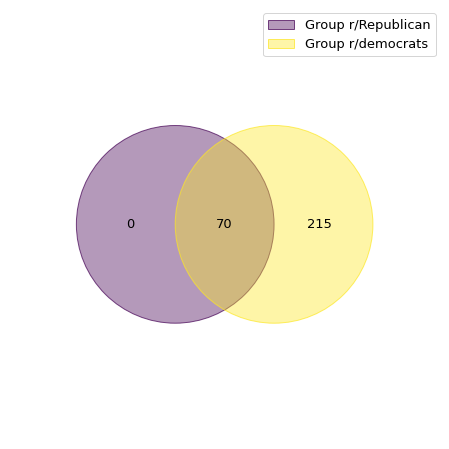

------------------ 2022-08-14 05:41:50 ------------------
DEBUG: at <ipython-input-113-0ce4e156d35d>:75 predict_groups_preferences
Figure saved in output/figures/preferred_subs/2_groups.png
------------------ 2022-08-14 05:41:50 ------------------
------------------ 2022-08-14 05:41:50 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/Conservative with users {2051, 27526, 28428, 29966, 19740, 27937, 25643, 11314, 27317, 13379, 707, 11075, 27643, 26445, 9677, 27983, 29391, 29137, 27475, 26334, 2017, 12770, 24419, 11242, 23660, 27118, 2802, 5748, 16249, 23931}
------------------ 2022-08-14 05:41:50 ------------------


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 71/71 [00:08<00:00,  8.69it/s]


  0%|          | 0/18120 [00:00<?, ?it/s]

------------------ 2022-08-14 05:42:01 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-113-0ce4e156d35d>:49 predict_groups_preferences
0 / 59.  ? pandas.core.series.Series with props ['_is_copy', '_mgr', '_item_cache', '_attrs', '_name', '_index'] val: 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
599    0.0
600    0.0
601    0.0
602    0.0
603    0.0
Name: r/Conservative, Length: 604, dtype: float64
------------------ 2022-08-14 05:42:01 ------------------
------------------ 2022-08-14 05:42:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/Conservative prefers 97/604 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_15qe1y', 't3_md913', 't3_g6zcob', 't3_fvq7yd', 't3_aulb9j', 't3_ccpp0y', 't3_e5nibh', 't3_e2nil3', 't3_5sthtf', 't3_eh3jb5', 't3_dlhdzo', 't3_5cqifz', 't3_2n1uw3', 't3_fuwd5r', 't3_2juyum', 't3_lcqya', 't3_el93md', 't3_g5vxg0', 't3_f5xl4z', 't3_fe9au5', 't3_d

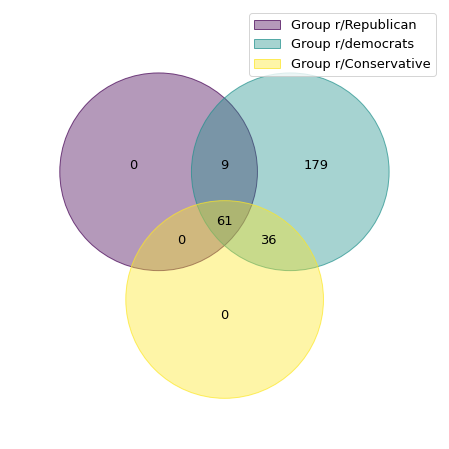

------------------ 2022-08-14 05:42:02 ------------------
DEBUG: at <ipython-input-113-0ce4e156d35d>:75 predict_groups_preferences
Figure saved in output/figures/preferred_subs/3_groups.png
------------------ 2022-08-14 05:42:02 ------------------
------------------ 2022-08-14 05:42:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/europe with users {15492, 17544, 25489, 15135, 18978, 22951, 1834, 19758, 6711, 13120, 24772, 15429, 25670, 26315, 6094, 10832, 4178, 210, 26584, 6246, 3943, 28774, 30705, 14963}
------------------ 2022-08-14 05:42:02 ------------------


  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 57/57 [00:06<00:00,  8.84it/s]


  0%|          | 0/14496 [00:00<?, ?it/s]

------------------ 2022-08-14 05:42:11 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-113-0ce4e156d35d>:49 predict_groups_preferences
0 / 60.  ? pandas.core.series.Series with props ['_is_copy', '_mgr', '_item_cache', '_attrs', '_name', '_index'] val: 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
599    0.0
600    0.0
601    0.0
602    0.0
603    0.0
Name: r/europe, Length: 604, dtype: float64
------------------ 2022-08-14 05:42:11 ------------------
------------------ 2022-08-14 05:42:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/europe prefers 158/604 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_g6zcob', 't3_fuwd5r', 't3_e5nibh', 't3_fvq7yd', 't3_f5xl4z', 't3_e2nil3', 't3_fe9au5', 't3_eh3jb5', 't3_md913', 't3_aulb9j', 't3_dlhdzo', 't3_ccpp0y', 't3_15qe1y', 't3_fmd3iy', 't3_gmpml5', 't3_fcy7tu', 't3_dmfz86', 't3_el93md', 't3_f3k2u0', 't3_gafqwy', 't3_g5vxg0', 't

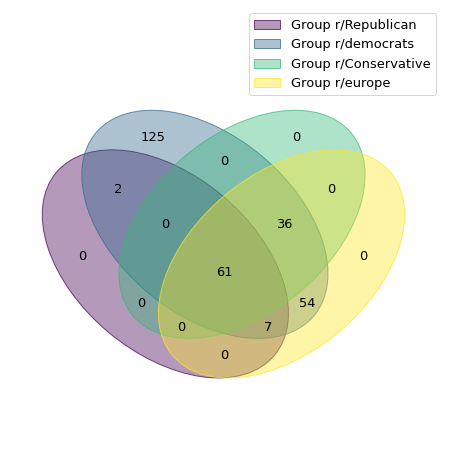

------------------ 2022-08-14 05:42:11 ------------------
DEBUG: at <ipython-input-113-0ce4e156d35d>:75 predict_groups_preferences
Figure saved in output/figures/preferred_subs/4_groups.png
------------------ 2022-08-14 05:42:11 ------------------
------------------ 2022-08-14 05:42:11 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/Libertarian with users {29505, 27362, 3426, 15108, 21798, 20487, 25862, 17610, 5772, 19246, 16787, 25524, 15064, 21017, 14427, 11484}
------------------ 2022-08-14 05:42:11 ------------------


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 38/38 [00:04<00:00,  8.77it/s]


  0%|          | 0/9664 [00:00<?, ?it/s]

------------------ 2022-08-14 05:42:17 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-113-0ce4e156d35d>:49 predict_groups_preferences
0 / 61.  ? pandas.core.series.Series with props ['_is_copy', '_mgr', '_item_cache', '_attrs', '_name', '_index'] val: 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
599    0.0
600    0.0
601    0.0
602    0.0
603    0.0
Name: r/Libertarian, Length: 604, dtype: float64
------------------ 2022-08-14 05:42:17 ------------------
------------------ 2022-08-14 05:42:17 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/Libertarian prefers 169/604 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_15qe1y', 't3_g6zcob', 't3_e5nibh', 't3_fvq7yd', 't3_5sthtf', 't3_dmfz86', 't3_md913', 't3_aulb9j', 't3_dlhdzo', 't3_ccpp0y', 't3_5cqifz', 't3_dt6vkd', 't3_fuwd5r', 't3_bbvdqo', 't3_f5xl4z', 't3_e2nil3', 't3_gmpml5', 't3_fe9au5', 't3_fcy7tu', 't3_eh3jb5', 't3_e

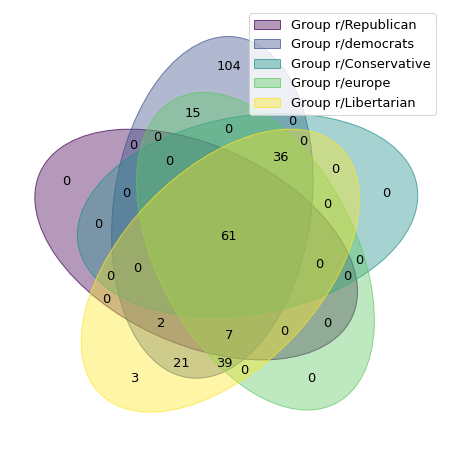

------------------ 2022-08-14 05:42:18 ------------------
DEBUG: at <ipython-input-113-0ce4e156d35d>:75 predict_groups_preferences
Figure saved in output/figures/preferred_subs/5_groups.png
------------------ 2022-08-14 05:42:18 ------------------
------------------ 2022-08-14 05:42:18 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Predicting group r/VoteBlue with users {29472, 3942, 21022, 3468, 17292, 30350, 26837, 3998}
------------------ 2022-08-14 05:42:18 ------------------


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:02<00:00,  9.03it/s]


  0%|          | 0/4832 [00:00<?, ?it/s]

------------------ 2022-08-14 05:42:21 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-113-0ce4e156d35d>:49 predict_groups_preferences
0 / 62.  ? pandas.core.series.Series with props ['_is_copy', '_mgr', '_item_cache', '_attrs', '_name', '_index'] val: 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
599    0.0
600    0.0
601    0.0
602    0.0
603    0.0
Name: r/VoteBlue, Length: 604, dtype: float64
------------------ 2022-08-14 05:42:21 ------------------
------------------ 2022-08-14 05:42:21 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:126 print_log
Users in group r/VoteBlue prefers 138/604 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_15qe1y', 't3_g6zcob', 't3_fvq7yd', 't3_md913', 't3_aulb9j', 't3_5cqifz', 't3_2n1uw3', 't3_agu62w', 't3_fuwd5r', 't3_e5nibh', 't3_bbvdqo', 't3_f5xl4z', 't3_ekv4k1', 't3_fmd3iy', 't3_e2nil3', 't3_fwwgm8', 't3_gmpml5', 't3_g1h0rg', 't3_fe9au5', 't3_5sthtf', 't3_fcy7tu'

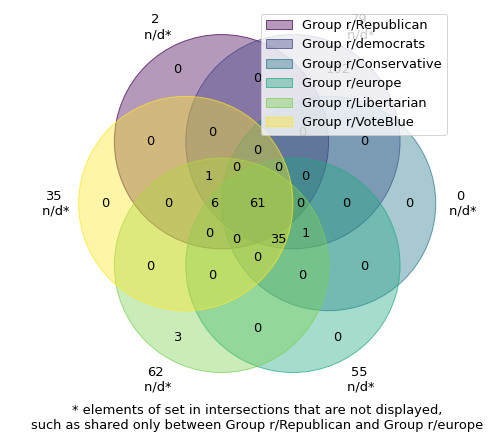

------------------ 2022-08-14 05:42:21 ------------------
DEBUG: at <ipython-input-113-0ce4e156d35d>:75 predict_groups_preferences
Figure saved in output/figures/preferred_subs/6_groups.png
------------------ 2022-08-14 05:42:21 ------------------


In [113]:
def predict_groups_preferences(users_in_groups, unique_submissions:dict, upvote_ratio_thres = 0.5, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes = None, pred_group_votes_info = None):
    # users_in_groups = existing_user_votes.most_common(3)
    groups_preferred_submissions = {}
    groups_preferred_submissions_text = {}
    # groups_submission_upvote_count_matrix = np.zeros([len(users_in_groups), len(unique_submissions)])
    groups_submission_upvote_count_matrix = pd.DataFrame(np.zeros([len(users_in_groups), len(unique_submissions)]), index = list(users_in_groups.keys()))
    unique_submissions_ids = list(unique_submissions.keys())
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if ((not ("single_user_as_group" in user_grouping_method and len(users_in_groups[group_x]) == 1)) and (not ("none" in user_grouping_method and len(users_in_groups[group_x]) == 0)) and len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"]) or ("all_user_as_group" not in user_grouping_method and len(users_in_groups[group_x]) > config["group_user_num_upper_thres"]): # keep middle sized centers
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if np.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                # continue
                print_log(config["log_path"], "Have similar center with existing group")
            used_group_centers.append(group_x_center)

        ################ predicting votes of some users and some submissions ##################
        print_log(config["log_path"], f"Predicting group {group_x} with users {users_in_groups[group_x]}")
        
        if len(users_in_groups[group_x]) > 0:
            group_x_subreddit_submissions_data = convert_group_users_subreddit_submissions_data(users_in_groups[group_x], unique_submissions)
            if group_x not in pred_group_votes_info:
                predicted_group_x_submissions_votes = predict_group_users_submissions_votes(model, group_x_subreddit_submissions_data, batch_size)
                group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_group_x_submissions_votes, users_in_groups[group_x], group_x_subreddit_submissions_data, existing_votes, upvote_confidence_thres=upvote_confidence_thres)
                
                pred_group_votes_info[group_x] = pred_group_x_subreddit_submission_vote_score_matrix
            else:
                debug("Using existing pred_group_votes_info")
                pred_group_x_subreddit_submission_vote_score_matrix = pred_group_votes_info[group_x]
                group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_user_submission_vote_score_matrix(None, users_in_groups[group_x], group_x_subreddit_submissions_data, existing_votes, existing_pred_user_submission_vote_score_matrix=pred_group_x_subreddit_submission_vote_score_matrix, upvote_confidence_thres=upvote_confidence_thres)
                # group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = pred_group_votes_info[group_x]
        elif len(users_in_groups[group_x]) == 0: # no user in this group, i.e., without curation, just count real votes
            group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_users_real_vote(list(a_subreddit_active_user_i_user_map.values()), unique_submissions, existing_votes, metric = "upvote_rate")
        
        group_x_preferred_submissions, group_x_preferred_submissions_ranking = get_group_users_preferred_submissions(group_x_submission_votes, upvote_ratio_thres = upvote_ratio_thres)
    
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix[unique_submissions_ids].to_numpy()
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix_np[pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=1) >= 0]
        groups_submission_upvote_count_matrix.loc[group_x] = pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=0).astype(float)/len(pred_group_x_subreddit_submission_vote_matrix_np)
        

        ################# Display submissions preferred by each group of users ######################

        if "single_user_as_group" in user_grouping_method:
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
            
        group_x_preferred_ranked_submissions = group_x_preferred_submissions_ranking[:len(group_x_preferred_submissions)]
        groups_preferred_submissions[f"Group {group_x}"] = group_x_preferred_submissions
        
        # convert submission text content
        group_x_preferred_ranked_submissions_text = get_submissions_text(group_x_preferred_ranked_submissions)
        groups_preferred_submissions_text[f"Group {group_x}"] = group_x_preferred_ranked_submissions_text
            
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_preferred_submissions)}/{len(unique_submissions)} submissions (%upvotes ≥ {upvote_ratio_thres}) (sorted using %upvotes): {group_x_preferred_ranked_submissions}, with text {group_x_preferred_ranked_submissions_text}") # 

        # draw venn diagram            
        if len(groups_preferred_submissions) > 1 and len(groups_preferred_submissions) <=6 and sum([len(_) for _ in groups_preferred_submissions.values()]) > 0:
            ax = venn(groups_preferred_submissions) if len(groups_preferred_submissions) <=5 else pseudovenn(groups_preferred_submissions)
            plt.show()
            figure_path = f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_preferred_submissions)}_groups.png"
            ax.figure.savefig(figure_path)
            debug(f"Figure saved in {figure_path}")
    return groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix

model = model.to(model.device); model.eval()
groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix = predict_groups_preferences(users_in_groups, submissions_before_curation, group_centers=group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes, pred_group_votes_info = pred_group_votes_info, upvote_ratio_thres = upvote_ratio_thres)
if config["submission_source"] == "custom":
    debug(groups_submission_upvote_count_matrix)
    print(f"You can post immediately in {[group_x for group_x in groups_preferred_submissions if len(groups_preferred_submissions[group_x]) > 0]}. You will need to wait for more votes to post in {[group_x for group_x in groups_preferred_submissions if len(groups_preferred_submissions[group_x]) == 0]} -- your post will stay in the background first. Currently, ", end = "")
    for group_x in groups_preferred_submissions:
        group_x_int = int(group_x.split(" ")[-1])
        print(f"{100 * groups_submission_upvote_count_matrix[group_x_int, 0]}% of the curators in {group_x} are predicted to upvote on your post; ", end = "")
        


##### Calculate Pearson correlation of different groups

In [117]:
print(groups_submission_upvote_count_matrix.index)
groups_submission_upvote_count_matrix_nonzero = groups_submission_upvote_count_matrix[groups_submission_upvote_count_matrix.sum(axis = 1) != 0]
group_preference_pearson_corr = np.corrcoef(groups_submission_upvote_count_matrix_nonzero) # (697, 697)
debug(group_preference_pearson_corr)

Index(['r/Republican', 'r/democrats', 'r/Conservative', 'r/europe',
       'r/Libertarian', 'r/VoteBlue'],
      dtype='object')
------------------ 2022-08-14 05:45:24 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-117-3d82fd370d8a>:4 <module>
0 / 65.  ? ndarray size: (6, 6) val: [[1.         0.77599462 0.9272538  0.90678249 0.85976231 0.89440083]
 [0.77599462 1.         0.84924945 0.8985604  0.8008126  0.83763293]
 [0.9272538  0.84924945 1.         0.96715287 0.93550363 0.94938132]
 [0.90678249 0.8985604  0.96715287 1.         0.92720292 0.92885574]
 [0.85976231 0.8008126  0.93550363 0.92720292 1.         0.94154579]
 [0.89440083 0.83763293 0.94938132 0.92885574 0.94154579 1.        ]]
------------------ 2022-08-14 05:45:24 ------------------


Group r/Republican: average sentiment 0.1000, all classes {}


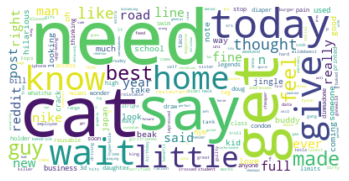

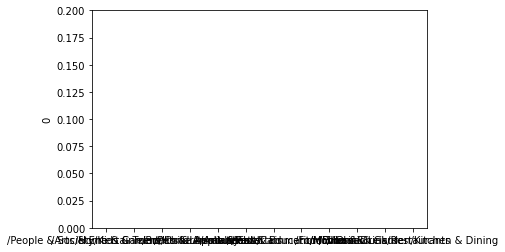

Group r/democrats: average sentiment 0.2786, all classes {'/Food & Drink/Restaurants': 0.0035087719298245615, '/Food & Drink': 0.0035087719298245615, '/Pets & Animals/Pets/Cats': 0.0035087719298245615, '/Hobbies & Leisure': 0.0035087719298245615, '/Arts & Entertainment': 0.0035087719298245615, '/Home & Garden/Home Appliances': 0.0035087719298245615, '/Home & Garden/Kitchen & Dining': 0.0035087719298245615, '/Books & Literature': 0.007017543859649123, '/Health': 0.0035087719298245615, '/Arts & Entertainment/Movies': 0.0035087719298245615, "/People & Society/Kids & Teens/Children's Interests": 0.0035087719298245615, '/Jobs & Education/Education': 0.0035087719298245615}


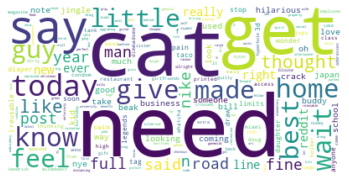

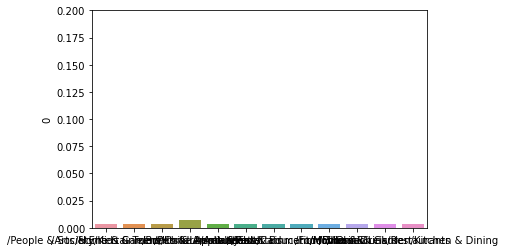

Group r/Conservative: average sentiment -0.2000, all classes {"/People & Society/Kids & Teens/Children's Interests": 0.010309278350515464}


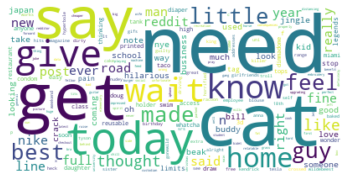

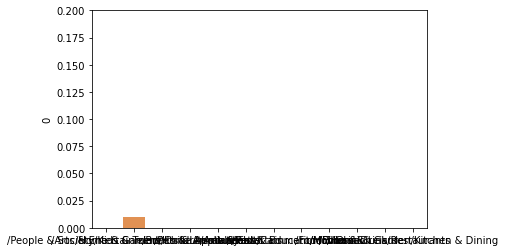

Group r/europe: average sentiment 0.2600, all classes {'/Food & Drink': 0.006329113924050633, "/People & Society/Kids & Teens/Children's Interests": 0.006329113924050633}


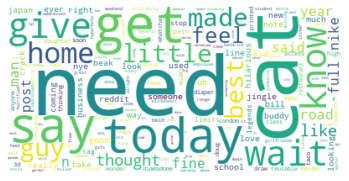

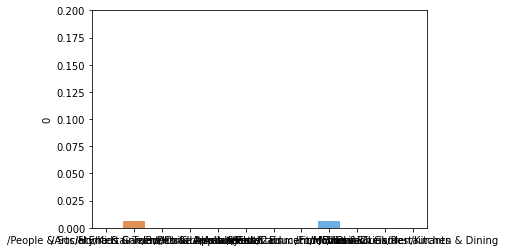

Group r/Libertarian: average sentiment 0.1857, all classes {'/Food & Drink': 0.005917159763313609, '/Books & Literature': 0.011834319526627219, "/People & Society/Kids & Teens/Children's Interests": 0.005917159763313609, '/Jobs & Education/Education': 0.005917159763313609}


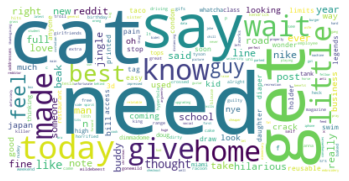

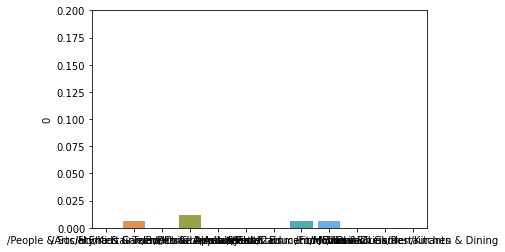

Group r/VoteBlue: average sentiment 0.2250, all classes {'/Food & Drink/Restaurants': 0.007246376811594203, "/People & Society/Kids & Teens/Children's Interests": 0.007246376811594203}


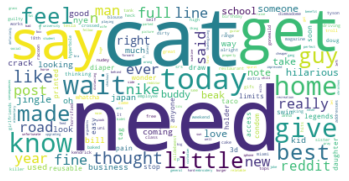

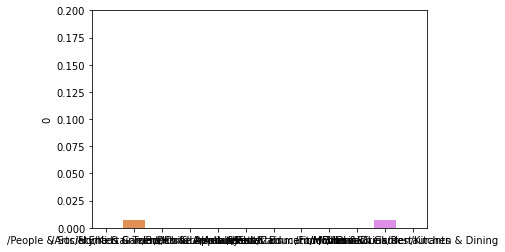

In [132]:
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

stop = set(stopwords.words('english'))
stop.update({"deleted", "SEP", "r"})
tokenizer = RegexpTokenizer(r'\w+')
submission_text_map = test_data[["SUBMISSION_ID", "SUBMISSION_TEXT"]].set_index("SUBMISSION_ID").to_dict()["SUBMISSION_TEXT"]
all_classes = set()
groups_class_counter_rate = {}
groups_sentiment = {}
groups_words = {}
for group_x in groups_preferred_submissions:
    submission_sentiments = []
    submission_classes = []
    submission_words = []
    group_preferred_submissions = groups_preferred_submissions[group_x]
    for submission_id in group_preferred_submissions:
        if submission_sentiment_map[submission_id]:
            submission_sentiments.append(submission_sentiment_map[submission_id])
        submission_classes.extend(submission_class_map[submission_id])
        submission_words.extend([_ for _ in tokenizer.tokenize(submission_text_map[submission_id].lower()) if _ not in stop])
        
    class_counter = Counter(submission_classes)
    all_classes.update(class_counter.keys())
    class_counter_rate = {k: v/len(group_preferred_submissions) for k, v in class_counter.items()}
    groups_class_counter_rate[group_x] = class_counter_rate
    
    avg_sentiment = np.mean(submission_sentiments) if len(submission_sentiments) > 0 else 0
    groups_sentiment[group_x] = avg_sentiment
    
    groups_words[group_x] = submission_words
all_classes = list(all_classes)
for group_x in groups_class_counter_rate:
    class_counter_rate = groups_class_counter_rate[group_x]
    print(f"{group_x}: average sentiment {groups_sentiment[group_x]:.4f}, all classes {class_counter_rate}") # , all words {Counter(groups_words[group_x])}
    
    # visualize wordcloud
    wordcloud = WordCloud(stopwords=stop, background_color="white").generate(" ".join(submission_words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.close()
    
    # visualize topic distribution
    class_counter_rate = {cls: [class_counter_rate.get(cls, 0)] for cls in all_classes}
    class_counter_rate_df = pd.DataFrame.from_dict(class_counter_rate).transpose()
    ax = sns.barplot(x=class_counter_rate_df.index, y=class_counter_rate_df[0])
    ax.set(ylim=(0, 0.2))
    plt.show()
    plt.close()